In [79]:
import sys
import numpy as np

import time
import sys
import warnings
import datetime
import gc
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
import os
import seaborn as sns
from pathlib import Path
import pickle
import plotly as pl

from sklearn.model_selection import GridSearchCV
import data_prep 
import data_summary
import lime_ModelExplainer
import data_split
#import plot_residual
import reading_data
import eda
from lime_ModelExplainer import lime_explainer
%matplotlib inline  

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

from imblearn.under_sampling import TomekLinks

from sklearn.decomposition import PCA
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

from scipy.stats import boxcox
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import mlModels
import pickle

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, log_loss, recall_score, roc_curve, roc_auc_score, confusion_matrix,classification_report 
from sklearn.metrics import  adjusted_mutual_info_score, balanced_accuracy_score
from sklearn.metrics import fbeta_score


from config_param import project_identifier
from directoryPath import mlresult_dir, parent_dir, parent_dir_project, mlresult_dir,  data_dir, input_dir, mlobjects
import directoryPath

sys.path.append('/datascience/home/ssaha/Test/')
sys.path.append('/datascience/home/ssaha/')
import h2o

In [ ]:
feats_r=["owned_lexus_LUV_no",
"owned_lexus_cpo_sedan_ind",
"active_brand",
"max_value_vehicles_per_hh",
"avg_no_repairs_under_warranty",
"owned_4wd_vehicle_ind",
"has_uss",
"avg_no_repairs_after_warranty",
"last_reported_mileage_recent_vehicle",
"days_since_last_purchase_vehicle",

"communication_clicked_ind",
"avg_cust_pay_0_6mo",
"avg_zip3_vehicle_val",
"no_ro_visits_24_36mo",
"last_purchase_vehicle_msrp",
"days_since_first_purchase_vehicle",
"no_cpro_visits",
"first_purchase_vehicle_msrp",
"est_current_mileage",
"no_repairs_under_warranty_most_recent_veh",
"no_repairs_after_warranty_most_recent_veh",
"presence_of_children",
"no_ro_visits_18_24mo",
"avg_mileage_permonth_recent_vehicle",
"avg_assoc_length",
"owned_lexus_sedan_no",
"avg_cust_pay_24_36mo",
"max_cust_pay_6_12mo",
"no_ro_visits_6_12mo",
"avg_custpay",
"generation_group",
"no_ro_visits_0_6mo",
"no_days_since_lastro_recent",
"avg_warrpay",
"max_service_assoc_length"]

In [8]:
gc.collect()

137

In [ ]:
start= time.time()
df_2016= reading_data.read_data(path="/datascience/home/ssaha/input/c360_customeradt_in_market_lexus_082016/")
print(time.time() -start)

In [ ]:
X=df_2016[feats_r].copy()

In [ ]:
start= time.time()
y = df_2016["dep_purchase_lexus_new_luv_6mo"] 
print(time.time() -start)

In [43]:

numerical_list = ['avg_custpay',
'avg_assoc_length',
'avg_mileage_permonth_recent_vehicle',
'est_current_mileage',
'first_purchase_vehicle_msrp',
'last_purchase_vehicle_msrp',
'avg_zip3_vehicle_val',
'avg_cust_pay_0_6mo',
'avg_warrpay',
'max_service_assoc_length',
'max_cust_pay_6_12mo',
'avg_cust_pay_24_36mo',
'last_reported_mileage_recent_vehicle']

In [31]:
X[numerical_list]=X[numerical_list].astype('float')

In [53]:
categorical_list=[x for x in feats_48 if x not in numerical_list]

In [54]:
len(categorical_list)

22

In [74]:
X[categorical_list]=X[categorical_list].astype('O')

In [75]:
start_time= time.time()
X[categorical_list]=X[categorical_list].apply(lambda x : x.fillna(0)) 
print(time.time()- start)

start_time= time.time()
X[numerical_list]=X[numerical_list].apply(lambda x: x.replace([np.inf, -np.inf], np.nan))
X[numerical_list]=X[numerical_list].apply(lambda x : x.fillna(x.mean()))  #if x.dtype.kind in 'bOSU' else fill_NaN.fit_transform(x)
print(time.time()- start)

791.9011943340302
797.5892729759216


In [ ]:
X.isnull().sum()

In [77]:
X_encoded= data_prep.label_encode(X)

KeyboardInterrupt: 

In [ ]:
X_train, X_test,y_train, y_test= data_split.train_test_split(X, y)

In [59]:
print('training set size',X_train.shape)
print('training set size',X_test.shape)

training set size (3556834, 35)
training set size (1185612, 35)


In [ ]:
log= mlModels.logistic_regression(X_train, y_train, X_test, y_test, False, C=.1, solver='newton-cg', dual=False, max_iter=1000)

In [126]:
X_old= pd.read_hdf(mlresult_dir+ 'c360_customeradt_in_market_lexus_20_X_2016.h5')

In [127]:
y_old= pd.read_hdf(mlresult_dir + 'c360_customeradt_in_market_lexus_20_y_2016.h5')

In [84]:
start= time.time()
rus, id_rus, X_rus, y_rus= data_prep.random_undersample(X_old, y_old)
print(time.time() -start)

Removed indexes: [4401525 3752992 1017693 ... 4742212 4742345 4742347]
3.366814374923706


In [86]:
X_rus.shape

(84732, 257)

In [88]:
y_rus.shape

(84732,)

In [89]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

In [90]:
rusknn = RepeatedEditedNearestNeighbours(return_indices=True)
X_rusknn, y_rusknn, id_rusknn = rus.fit_sample(X_old, y_old)
X_rusknn= pd.DataFrame(X_rusknn, columns=X_old.columns)
y_rusknn= pd.Series(y_rusknn, name=y.name)

In [91]:
X_rusknn.shape

(84732, 257)

#### 80:20

In [116]:
X_old.shape

(4742446, 257)

In [117]:
y_old.shape

(4742446,)

In [ ]:
train.shape

In [130]:
from sklearn.utils import resample

In [145]:
# Separate majority and minority classes  ### 1min
train_majority = X_old.iloc[y_old[y_old==0].index]


train_minority = X_old.iloc[y_old[y_old==1].index]


#train_sampled=pd.DataFrame(None)
# Upsample minority class
train_majority_sampled = resample(train_majority, 
                                 replace=False,     # sample without replacement
                                 n_samples=np.round(train_minority.shape[0]*9),    # to match majority class
                                 random_state=123) # reproducible results
'''train_minority_sampled = resample(train_minority, 
                                 replace=False,     # sample without replacement
                                 n_samples=np.round(train_minority.shape[0]*1),    # to match majority class
                                 random_state=123)'''


# Combine majority class with upsampled minority class
train_sampled = pd.concat([train_majority_sampled, train_minority])


In [149]:
 
# Display new class counts
train_sampled.iloc[y_old[y_old==0].index].shape

(4700080, 257)

In [150]:
train_sampled.iloc[y_old[y_old==1].index].shape

(42366, 257)

In [151]:
train_sampled.shape

(423660, 257)

In [152]:
y_old.shape

(4742446,)

In [161]:
X_old_xgb_selected= train_sampled[["days_since_last_purchase_vehicle",
"max_value_vehicles_per_hh",
"customer_language_english_ind",
"driver_ind",
"days_since_first_purchase_vehicle",
"current_owned_lexus_new_luv_ind",
"second_last_purchase_age",
"last_reported_mileage_recent_vehicle",
"avg_zip3_vehicle_val",
"length_of_residence",
"no_ro_visits_48_60mo",
"association_type",
"owned_lexus_new_luv_ind",
"current_owned_lexus_LUV_ind",
"avg_mileage_permonth_recent_vehicle",
"no_leased_vehicle",
"noros_high_ro_time_0_6mo",
"owned_rx_ind",
"purchased_vehicle_used_ind",
"purchased_vehicle_lexus_LUV_ind",
"ever_warranty_payment_ind",
"avg_service_assoc_length",
"last_serviced_dealer_no",
"purchased_lexus_LUV_last_3years_ind",
"communication_received_ind",
"communication_clicked_ind",
"ever_service_lexus_LUV_ind",
"first_purchase_vehicle_msrp",
"avg_cust_pay_36_48mo",
"avg_cust_pay_24_36mo",
"avg_ro_time_18_24mo",
"no_ro_visits_12_18mo",
"pma_toy_scion_dealership_cd",
"pma_lexus_dealership_cd",
"owned_big_engine_vehicle_ind",
"dofu_year1_ind",
"pma_lexus_dealership_region",
"avg_ro_time_6_12mo",
"last_serviced_dealer_region",
"gndr_cd",
"owned_silver_gray_vehicle_ind",
"purchased_lexus_last_3years_ind",
"service_survey_ind",
"has_uss",
"ever_lead_ind",
"ever_handraiser_ind",
"i1_occupation_grp_val",
"avg_custpay_recent_vehicle",
"avg_ro_time_0_6mo",
"est_current_mileage",
"pma_toy_scion_dealership_region",
"active_brand",
"owned_lexus_ind",
"owned_vehicle_my_2011_20_ind",
"purchased_lexus_sedan_last_2years_ind",
"current_owned_es_ind",
"purchased_vehicle_new_ind",
"brochure_requested_ind",
"avg_no_vehicles_per_hh",
"avg_ro_time_12_18mo",
"home_ownership",
"owned_lexus_LUV_ind",
"owned_is250_ind",
"owned_es_ind",
"owned_other_color_vehicle_ind",
"purchased_vehicle_last_2years_ind",
"purchased_lexus_LUV_last_2years_ind",
"past_owned_lexus_new_sedan_ind",
"sales_survey_ind",
"high_service_ind",
"no_sales_dealer_assoc",
"no_of_adlts_per_hh_cd",
"no_ro_visits_0_6mo",
"noros_high_ro_time_6_12mo",
"marital_status_confidence",
"owned_ct200h_ind",
"owned_aqua_vehicle_ind",
"purchased_is_last_3years_ind",
"current_owned_lexus_new_sedan_ind",
"current_owned_gs_ind",
"past_owned_lexus_sedan_ind",
"past_owned_lexus_LUV_ind",
"purchased_vehicle_4wd_ind",
"past_owned_toyota_4wd_ind",
"ever_service_hybrid_ind",
"last_sales_dealer_region",
"avg_cust_pay_48_60mo",
"noros_high_ro_time_12_18mo"]]

In [162]:
X_train, X_test,y_train, y_test= data_split.train_test_split(X_old_xgb_selected, y_old.iloc[train_sampled.index])

cross_val_score [0.99247836 0.99321783 0.99309194 0.99317062 0.99302889]
accuracy 99.5741868479441
balanced_accuracy_score 79.3119266055046
f1_score 86.85044973095908
precision_score 99.57601102184488
Log loss 0.14707065244870718
recall_score 58.62385321100917


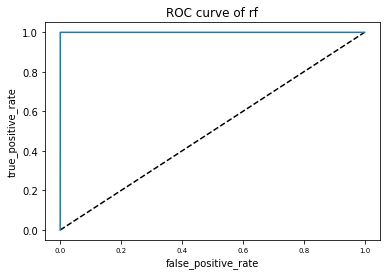

roc_auc_score 99.99977157210466
confusion_matrix [[104825      0]
 [   451    639]]
classification_report              precision    recall  f1-score   support

           0       1.00      1.00      1.00    104825
           1       1.00      0.59      0.74      1090

   micro avg       1.00      1.00      1.00    105915
   macro avg       1.00      0.79      0.87    105915
weighted avg       1.00      1.00      1.00    105915


 Time taken to execute the rf is 2.4612228870391846

Dated on2019-01-21 04:28:24.483300



In [164]:
rf= mlModels.rf(X_train, y_train, X_test, y_test)

In [155]:
X_old_test= pd.read_hdf(mlresult_dir + 'c360_customeradt_in_market_lexus_25_X_2017.h5')

y_old_test = pd.read_hdf(mlresult_dir + 'c360_customeradt_in_market_lexus_25_y_2017.h5')

In [157]:
import model_evaluation

In [166]:
X_old_test_xgb_selected= X_old_test[X_old_xgb_selected.columns.tolist()]

Provided model : 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=40,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
accuracy  99.12361675463498


/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



f1_score  49.779939903752116


/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.



precision_score  98.25491398519752
recall_score  0.0
confusion_matrix 
 [[5026514       0]
 [  44441       0]]
days_since_last_purchase_vehicle 0.03790967285328002
max_value_vehicles_per_hh 0.04218051499236816
customer_language_english_ind 0.017425054552162537
driver_ind 0.007444120207359613
days_since_first_purchase_vehicle 0.03859103650058219
current_owned_lexus_new_luv_ind 0.004668499104554783
second_last_purchase_age 0.020067595660145328
last_reported_mileage_recent_vehicle 0.036275855047693685
avg_zip3_vehicle_val 0.0368775979906665
length_of_residence 0.03276958711745477
no_ro_visits_48_60mo 0.012442947091707745
association_type 0.0020575902546163764
owned_lexus_new_luv_ind 0.0037884815191490547
current_owned_lexus_LUV_ind 0.0022924564326244163
avg_mileage_permonth_recent_vehicle 0.03839995613754378
no_leased_vehicle 0.0015986918973777211
noros_high_ro_time_0_6mo 0.007407661002679776
owned_rx_ind 0.003238665597073761
purchased_vehicle_used_ind 0.0011827796262682251
purchased_vehi

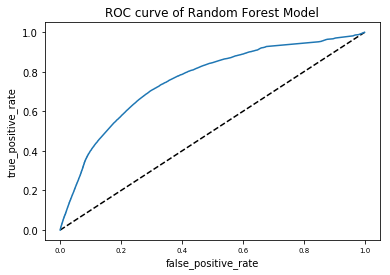

In [167]:
model_evaluation.model_evaluation_test(X_old_test_xgb_selected, y_old_test, rf, alg_name='Random Forest Model', feat_imp=True, roc=True)

In [334]:
from imblearn.under_sampling import RandomUnderSampler

In [337]:
rusknn = RandomUnderSampler(return_indices=True, sampling_strategy={0:.8})
X_rus, y_rus, id_rus = rus.fit_sample(X_old, y_old)
X_rus= pd.DataFrame(X_rus, columns=X_old.columns)
y_rus= pd.Series(y_rus, name=y.name)

In [339]:
y_rusknn.value_counts()

1    42366
0    42366
Name: dep_purchase_lexus_new_luv_6mo, dtype: int64

In [204]:
from imblearn.under_sampling import OneSidedSelection

In [242]:
X_rusknn.shape

(84732, 257)

#### 50:50

In [239]:
rusknn = RepeatedEditedNearestNeighbours(return_indices=True, sampling_strategy=.8)
X_rusknn, y_rusknn, id_rusknn = rus.fit_sample(X_old, y_old)
X_rusknn= pd.DataFrame(X_rusknn, columns=X_old.columns)
y_rusknn= pd.Series(y_rusknn, name=y.name)

In [209]:
X_rusknn.shape

(84732, 257)

In [211]:
X_old.shape

(4742446, 257)

In [210]:
y_rusknn.value_counts()

1    42366
0    42366
Name: dep_purchase_lexus_new_luv_6mo, dtype: int64

In [107]:
y_old.value_counts()

0    4700080
1      42366
Name: dep_purchase_lexus_new_luv_6mo, dtype: int64

In [243]:
X_rusknn_xgb_selected= X_rusknn[["days_since_last_purchase_vehicle",
"max_value_vehicles_per_hh",
"customer_language_english_ind",
"driver_ind",
"days_since_first_purchase_vehicle",
"current_owned_lexus_new_luv_ind",
"second_last_purchase_age",
"last_reported_mileage_recent_vehicle",
"avg_zip3_vehicle_val",
"length_of_residence",
"no_ro_visits_48_60mo",
"association_type",
"owned_lexus_new_luv_ind",
"current_owned_lexus_LUV_ind",
"avg_mileage_permonth_recent_vehicle",
"no_leased_vehicle",
"noros_high_ro_time_0_6mo",
"owned_rx_ind",
"purchased_vehicle_used_ind",
"purchased_vehicle_lexus_LUV_ind",
"ever_warranty_payment_ind",
"avg_service_assoc_length",
"last_serviced_dealer_no",
"purchased_lexus_LUV_last_3years_ind",
"communication_received_ind",
"communication_clicked_ind",
"ever_service_lexus_LUV_ind",
"first_purchase_vehicle_msrp",
"avg_cust_pay_36_48mo",
"avg_cust_pay_24_36mo",
"avg_ro_time_18_24mo",
"no_ro_visits_12_18mo",
"pma_toy_scion_dealership_cd",
"pma_lexus_dealership_cd",
"owned_big_engine_vehicle_ind",
"dofu_year1_ind",
"pma_lexus_dealership_region",
"avg_ro_time_6_12mo",
"last_serviced_dealer_region",
"gndr_cd",
"owned_silver_gray_vehicle_ind",
"purchased_lexus_last_3years_ind",
"service_survey_ind",
"has_uss",
"ever_lead_ind",
"ever_handraiser_ind",
"i1_occupation_grp_val",
"avg_custpay_recent_vehicle",
"avg_ro_time_0_6mo",
"est_current_mileage",
"pma_toy_scion_dealership_region",
"active_brand",
"owned_lexus_ind",
"owned_vehicle_my_2011_20_ind",
"purchased_lexus_sedan_last_2years_ind",
"current_owned_es_ind",
"purchased_vehicle_new_ind",
"brochure_requested_ind",
"avg_no_vehicles_per_hh",
"avg_ro_time_12_18mo",
"home_ownership",
"owned_lexus_LUV_ind",
"owned_is250_ind",
"owned_es_ind",
"owned_other_color_vehicle_ind",
"purchased_vehicle_last_2years_ind",
"purchased_lexus_LUV_last_2years_ind",
"past_owned_lexus_new_sedan_ind",
"sales_survey_ind",
"high_service_ind",
"no_sales_dealer_assoc",
"no_of_adlts_per_hh_cd",
"no_ro_visits_0_6mo",
"noros_high_ro_time_6_12mo",
"marital_status_confidence",
"owned_ct200h_ind",
"owned_aqua_vehicle_ind",
"purchased_is_last_3years_ind",
"current_owned_lexus_new_sedan_ind",
"current_owned_gs_ind",
"past_owned_lexus_sedan_ind",
"past_owned_lexus_LUV_ind",
"purchased_vehicle_4wd_ind",
"past_owned_toyota_4wd_ind",
"ever_service_hybrid_ind",
"last_sales_dealer_region",
"avg_cust_pay_48_60mo",
"noros_high_ro_time_12_18mo"]]

In [244]:
X_train, X_test,y_train, y_test= data_split.train_test_split(X_rusknn_xgb_selected, y_rusknn)

cross_val_score [0.82109983 0.83093384 0.8270517  0.82689433 0.83114328]
accuracy 82.75503941840154
balanced_accuracy_score 82.75676002322912
f1_score 82.66341100584886
precision_score 83.46772888329882
Log loss 5.95629647945663
recall_score 90.0462744357352


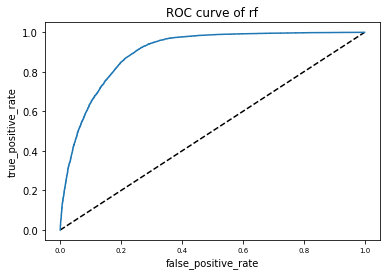

roc_auc_score 90.02155119350917
confusion_matrix [[7995 2599]
 [1054 9535]]
classification_report              precision    recall  f1-score   support

           0       0.88      0.75      0.81     10594
           1       0.79      0.90      0.84     10589

   micro avg       0.83      0.83      0.83     21183
   macro avg       0.83      0.83      0.83     21183
weighted avg       0.83      0.83      0.83     21183


 Time taken to execute the rf is 0.8444969654083252

Dated on2019-01-21 08:17:10.690743



In [267]:
rf_rus_knn= mlModels.rf(X_train, y_train, X_test, y_test, min_samples_split=50, n_estimators=100)

Provided model : 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
accuracy  86.69465613479119
f1_score  49.41377745632675
precision_score  98.63411441393262
recall_score  48.34049638847011
confusion_matrix 
 [[4374764  651750]
 [  22958   21483]]
days_since_last_purchase_vehicle 0.04526496695509076
max_value_vehicles_per_hh 0.02288297419440948
customer_language_english_ind 0.3674547035694108
driver_ind 0.018251325755161318
days_since_first_purchase_vehicle 0.019457466806699356
current_owned_lexus_new_luv_ind 0.03151574782322914
second_last_purchase_age 0.014013030829759403
last_reported_mileage_recent_vehicle 0.01067949801770233

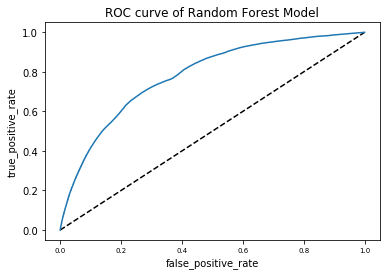

In [268]:
model_evaluation.model_evaluation_test(X_old_test_xgb_selected, y_old_test, rf_rus_knn, alg_name='Random Forest Model', feat_imp=True, roc=True)

Provided model : 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
accuracy  85.28379675525971
f1_score  85.20826935225772
precision_score  86.01766163514465
recall_score  92.42219215155616
confusion_matrix 
 [[24828  6944]
 [ 2408 29369]]
days_since_last_purchase_vehicle 0.04526496695509076
max_value_vehicles_per_hh 0.02288297419440948
customer_language_english_ind 0.3674547035694108
driver_ind 0.018251325755161318
days_since_first_purchase_vehicle 0.019457466806699356
current_owned_lexus_new_luv_ind 0.03151574782322914
second_last_purchase_age 0.014013030829759403
last_reported_mileage_recent_vehicle 0.010679498017702332
avg_zi

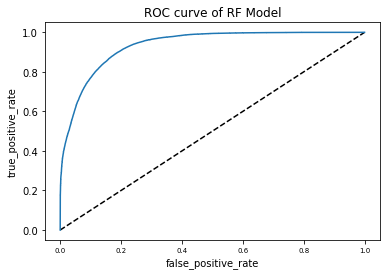

In [269]:
model_evaluation.model_evaluation_test(X_train, y_train, rf_rus_knn, alg_name='RF Model', feat_imp=True, roc=True)

cross_val_score [0.82039179 0.83179923 0.82595011 0.82595011 0.82901881]
accuracy 82.79752631827408
balanced_accuracy_score 82.79921906841999
f1_score 82.70908231816003
precision_score 83.4877592937863
Log loss 5.941621382411335
recall_score 89.97072433657569


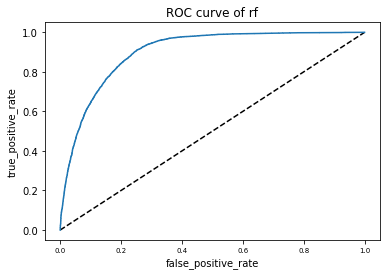

roc_auc_score 90.02147765090038
confusion_matrix [[8012 2582]
 [1062 9527]]
classification_report              precision    recall  f1-score   support

           0       0.88      0.76      0.81     10594
           1       0.79      0.90      0.84     10589

   micro avg       0.83      0.83      0.83     21183
   macro avg       0.83      0.83      0.83     21183
weighted avg       0.83      0.83      0.83     21183


 Time taken to execute the rf is 0.8096954822540283

Dated on2019-01-21 08:18:21.925241



In [270]:
rf_rus_knn= mlModels.rf(X_train, y_train, X_test, y_test, min_samples_split=40, n_estimators=80)

Provided model : 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=40,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
accuracy  89.0360099823406
f1_score  50.27830135761493
precision_score  98.59485073334523
recall_score  42.625053441641725
confusion_matrix 
 [[4496033  530481]
 [  25498   18943]]
days_since_last_purchase_vehicle 0.04490304029399523
max_value_vehicles_per_hh 0.0222225676394194
customer_language_english_ind 0.36054257737430634
driver_ind 0.017754674997410888
days_since_first_purchase_vehicle 0.021085477810076938
current_owned_lexus_new_luv_ind 0.02930948287198561
second_last_purchase_age 0.01141676587360212
last_reported_mileage_recent_vehicle 0.00991082554452129
a

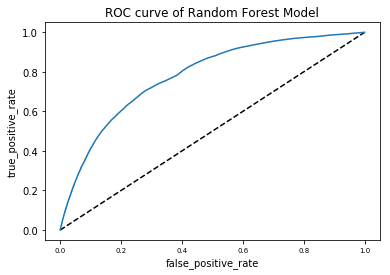

In [271]:
model_evaluation.model_evaluation_test(X_old_test_xgb_selected, y_old_test, rf_rus_knn, alg_name='Random Forest Model', feat_imp=True, roc=True)

Provided model : 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=40,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
accuracy  85.5072463768116
f1_score  85.43560560481004
precision_score  86.21811723445983
recall_score  92.51345312647513
confusion_matrix 
 [[24941  6831]
 [ 2379 29398]]
days_since_last_purchase_vehicle 0.04490304029399523
max_value_vehicles_per_hh 0.0222225676394194
customer_language_english_ind 0.36054257737430634
driver_ind 0.017754674997410888
days_since_first_purchase_vehicle 0.021085477810076938
current_owned_lexus_new_luv_ind 0.02930948287198561
second_last_purchase_age 0.01141676587360212
last_reported_mileage_recent_vehicle 0.00991082554452129
avg_zip3_v

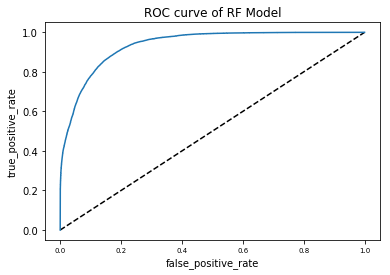

In [272]:
model_evaluation.model_evaluation_test(X_train, y_train, rf_rus_knn, alg_name='RF Model', feat_imp=True, roc=True)

In [ ]:
rf_rus_knn= mlModels.rf(X_train, y_train, X_test, y_test, min_samples_split=40, n_estimators=50)

In [ ]:
model_evaluation.model_evaluation_test(X_old_test_xgb_selected, y_old_test, rf_rus_knn, alg_name='Random Forest Model', feat_imp=True, roc=True)

In [ ]:
model_evaluation.model_evaluation_test(X_train, y_train, rf_rus_knn, alg_name='RF Model', feat_imp=True, roc=True)

In [183]:
X_old_xgb_selected.shape

(423660, 88)

In [184]:
X_old.shape

(4742446, 257)

cross_val_score [0.82566281 0.83549681 0.82815328 0.83326776 0.8325596 ]
accuracy 83.48203748288722
balanced_accuracy_score 83.48390521343643
f1_score 83.37848315173862
precision_score 84.34357770880699
Log loss 5.705199828350178
recall_score 91.39673245821135


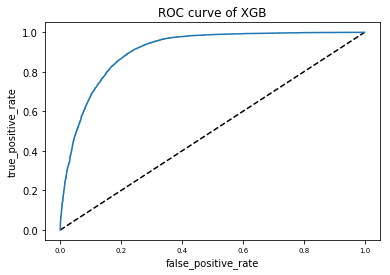

roc_auc_score 90.75318604855526
confusion_matrix [[8006 2588]
 [ 911 9678]]
classification_report              precision    recall  f1-score   support

           0       0.90      0.76      0.82     10594
           1       0.79      0.91      0.85     10589

   micro avg       0.83      0.83      0.83     21183
   macro avg       0.84      0.83      0.83     21183
weighted avg       0.84      0.83      0.83     21183


 Time taken to execute the XGB is 2.6432600021362305

Dated on2019-01-21 07:13:51.251118



In [255]:
xgb_rus_knn= mlModels.xgb(X_train, y_train, X_test, y_test, n_estimators=200)

Provided model : 
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=0, n_estimators=200,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
accuracy  83.79360808195251
f1_score  83.6982650575649
precision_score  84.60124932003842
recall_score  91.43405607829563
confusion_matrix 
 [[24195  7577]
 [ 2722 29055]]
days_since_last_purchase_vehicle 0.11127168
max_value_vehicles_per_hh 0.10765896
customer_language_english_ind 0.050578035
driver_ind 0.03251445
days_since_first_purchase_vehicle 0.04479769
current_owned_lexus_new_luv_ind 0.0072254334
second_last_purchase_age 0.033959538
last_reported_mileage_recent_vehicle 0.03612717
avg_zip3_vehicle_val 0.033959538
length_of_residence 0.023121387
no_ro_visits_48_60mo 0.01300578
assoc

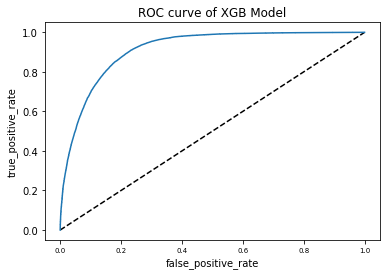

In [259]:
model_evaluation.model_evaluation_test(X_train, y_train, xgb_rus_knn, alg_name='XGB Model', feat_imp=True, roc=True)

Provided model : 
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=0, n_estimators=200,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
accuracy  95.55519621057572
f1_score  52.61121856779365
precision_score  98.44548956434355
recall_score  20.559843387862557
confusion_matrix 
 [[4836424  190090]
 [  35304    9137]]
days_since_last_purchase_vehicle 0.11127168
max_value_vehicles_per_hh 0.10765896
customer_language_english_ind 0.050578035
driver_ind 0.03251445
days_since_first_purchase_vehicle 0.04479769
current_owned_lexus_new_luv_ind 0.0072254334
second_last_purchase_age 0.033959538
last_reported_mileage_recent_vehicle 0.03612717
avg_zip3_vehicle_val 0.033959538
length_of_residence 0.023121387
no_ro_visits_48_60mo 0.0130

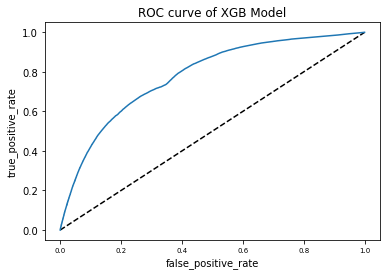

In [256]:
model_evaluation.model_evaluation_test(X_old_test_xgb_selected, y_old_test, xgb_rus_knn, alg_name='XGB Model', feat_imp=True, roc=True)

cross_val_score [0.82487609 0.83486744 0.82878275 0.83271697 0.83145802]
accuracy 83.21295378369447
balanced_accuracy_score 83.21489615614267
f1_score 83.0990507399664
precision_score 84.13915001273544
Log loss 5.798140385851505
recall_score 91.44395127018605


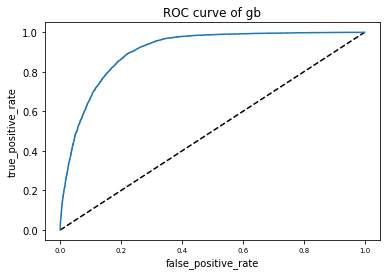

roc_auc_score 90.622348844667
confusion_matrix [[7944 2650]
 [ 906 9683]]
classification_report              precision    recall  f1-score   support

           0       0.90      0.75      0.82     10594
           1       0.79      0.91      0.84     10589

   micro avg       0.83      0.83      0.83     21183
   macro avg       0.84      0.83      0.83     21183
weighted avg       0.84      0.83      0.83     21183


 Time taken to execute the gb is 40.87076663970947

Dated on2019-01-21 07:17:54.827672



In [257]:
gb_rus= mlModels.gb(X_train, y_train, X_test, y_test, n_estimators=150, min_samples_split=40)

Provided model : 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=40,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
accuracy  98.74514761026276
f1_score  51.65714378245823
precision_score  98.32934930712723
recall_score  2.9409779257892485
confusion_matrix 
 [[5006015   20499]
 [  43134    1307]]
days_since_last_purchase_vehicle 0.04536099000782149
max_value_vehicles_per_hh 0.027427867479445568
customer_language_english_ind 0.7927202692072751
driver_ind 0.013064145463653438
days_since_first_purchase_vehicle 0.008606178695170687
current_owned_lex

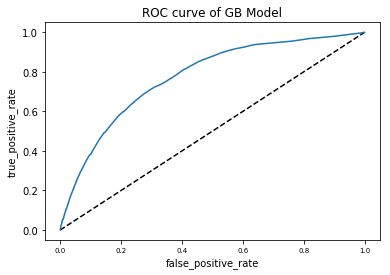

In [258]:
model_evaluation.model_evaluation_test(X_old_test_xgb_selected, y_old_test, gb_rus, alg_name='GB Model', feat_imp=True, roc=True)

In [273]:
#X_rusknn, y_rusknn
X_rusknn_selected_42= X_rusknn[["no_ro_visits_12_18mo",
"no_ro_visits_0_6mo",
"est_current_mileage",
"no_ro_visits_48_60mo",
"last_reported_mileage_recent_vehicle",
"has_uss",
"owned_aqua_vehicle_ind",
"owned_silver_gray_vehicle_ind",
"avg_custpay_recent_vehicle",
"purchased_vehicle_last_2years_ind",
"avg_ro_time_6_12mo",
"owned_lexus_new_luv_ind",
"current_owned_lexus_new_luv_ind",
"owned_vehicle_my_2011_20_ind",
"dofu_year1_ind",
"current_owned_lexus_LUV_ind",
"ever_service_lexus_LUV_ind",
"owned_lexus_LUV_ind",
"days_since_last_purchase_vehicle",
"max_value_vehicles_per_hh",
"customer_language_english_ind",
"days_since_first_purchase_vehicle",
"second_last_purchase_age",
"avg_zip3_vehicle_val",
"driver_ind",
"avg_mileage_permonth_recent_vehicle",
"last_serviced_dealer_no",
"length_of_residence",
"first_purchase_vehicle_msrp",
"avg_cust_pay_48_60mo",
"avg_no_vehicles_per_hh",
"avg_ro_time_12_18mo",
"avg_service_assoc_length",
"pma_toy_scion_dealership_cd",
"avg_cust_pay_24_36mo",
"association_type",
"pma_lexus_dealership_cd",
"no_leased_vehicle",
"avg_cust_pay_36_48mo",
"communication_received_ind",
"noros_high_ro_time_0_6mo",
"avg_ro_time_0_6mo"]]

In [274]:
X_train, X_test,y_train, y_test= data_split.train_test_split(X_rusknn_selected_42, y_rusknn)

cross_val_score [0.82983243 0.82755094 0.83263829 0.8265009  0.82185853]
accuracy 82.93914931784921
balanced_accuracy_score 83.00349747059602
f1_score 82.83965003676607
precision_score 83.91469872831469
Log loss 5.892710834437001
recall_score 91.26463031687125


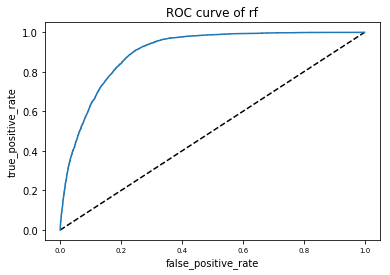

roc_auc_score 89.96346903810225
confusion_matrix [[7978 2696]
 [ 918 9591]]
classification_report              precision    recall  f1-score   support

           0       0.90      0.75      0.82     10674
           1       0.78      0.91      0.84     10509

   micro avg       0.83      0.83      0.83     21183
   macro avg       0.84      0.83      0.83     21183
weighted avg       0.84      0.83      0.83     21183


 Time taken to execute the rf is 0.7366399765014648

Dated on2019-01-22 00:22:34.408064



In [278]:
rf_42= mlModels.rf(X_train, y_train, X_test, y_test, n_estimators=80, min_samples_split=50)

Provided model : 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
accuracy  85.28851752191223
f1_score  85.19019432056747
precision_score  86.1838745182619
recall_score  93.19458831653954
confusion_matrix 
 [[24511  7181]
 [ 2168 29689]]
roc_auc_score 93.62781195189467


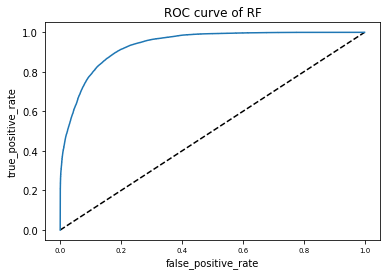

In [282]:
model_evaluation.model_evaluation_test(X_train, y_train, rf_42, alg_name='RF')

In [279]:
#X_rusknn, y_rusknn
X_app_rusknn_selected_42= X_old_test[["no_ro_visits_12_18mo",
"no_ro_visits_0_6mo",
"est_current_mileage",
"no_ro_visits_48_60mo",
"last_reported_mileage_recent_vehicle",
"has_uss",
"owned_aqua_vehicle_ind",
"owned_silver_gray_vehicle_ind",
"avg_custpay_recent_vehicle",
"purchased_vehicle_last_2years_ind",
"avg_ro_time_6_12mo",
"owned_lexus_new_luv_ind",
"current_owned_lexus_new_luv_ind",
"owned_vehicle_my_2011_20_ind",
"dofu_year1_ind",
"current_owned_lexus_LUV_ind",
"ever_service_lexus_LUV_ind",
"owned_lexus_LUV_ind",
"days_since_last_purchase_vehicle",
"max_value_vehicles_per_hh",
"customer_language_english_ind",
"days_since_first_purchase_vehicle",
"second_last_purchase_age",
"avg_zip3_vehicle_val",
"driver_ind",
"avg_mileage_permonth_recent_vehicle",
"last_serviced_dealer_no",
"length_of_residence",
"first_purchase_vehicle_msrp",
"avg_cust_pay_48_60mo",
"avg_no_vehicles_per_hh",
"avg_ro_time_12_18mo",
"avg_service_assoc_length",
"pma_toy_scion_dealership_cd",
"avg_cust_pay_24_36mo",
"association_type",
"pma_lexus_dealership_cd",
"no_leased_vehicle",
"avg_cust_pay_36_48mo",
"communication_received_ind",
"noros_high_ro_time_0_6mo",
"avg_ro_time_0_6mo"]]

Provided model : 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
accuracy  91.29708309381567
f1_score  50.56461034037126
precision_score  98.48731809032564
recall_score  29.963322157467204
confusion_matrix 
 [[4616318  410196]
 [  31125   13316]]
no_ro_visits_12_18mo 0.008870883676247335
no_ro_visits_0_6mo 0.014039711829134513
est_current_mileage 0.025492919973439183
no_ro_visits_48_60mo 0.004010144371839828
last_reported_mileage_recent_vehicle 0.0164021341597252
has_uss 0.003835804811534959
owned_aqua_vehicle_ind 0.0012053023303529033
owned_silver_gray_vehicle_ind 0.0006855251105053071
avg_custpay_recent_vehicle 0.0063580281607

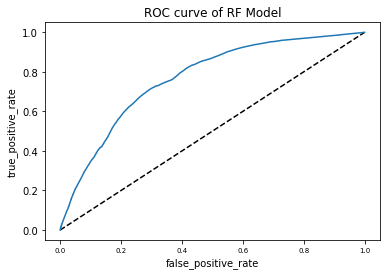

In [280]:
model_evaluation.model_evaluation_test(X_app_rusknn_selected_42, y_old_test, rf_42, alg_name='RF Model', feat_imp=True, roc=True)

cross_val_score [0.83400205 0.83116985 0.8335825  0.82894012 0.82642222]
accuracy 83.17046688382193
balanced_accuracy_score 83.22979109798068
f1_score 83.08835925186546
precision_score 84.00510698761762
Log loss 5.812813067080556
recall_score 90.84594157388905


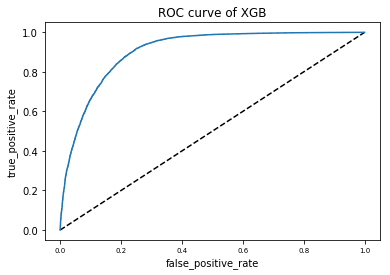

roc_auc_score 90.52017397830599
confusion_matrix [[8071 2603]
 [ 962 9547]]
classification_report              precision    recall  f1-score   support

           0       0.89      0.76      0.82     10674
           1       0.79      0.91      0.84     10509

   micro avg       0.83      0.83      0.83     21183
   macro avg       0.84      0.83      0.83     21183
weighted avg       0.84      0.83      0.83     21183


 Time taken to execute the XGB is 2.24737548828125

Dated on2019-01-22 00:47:48.599720



In [311]:
xgb_42= mlModels.xgb(X_train, y_train, X_test, y_test, learning_rate=.1, n_estimators=250)

Provided model : 
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=0, n_estimators=250,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
accuracy  83.76843065980582
f1_score  83.6666717833842
precision_score  84.56835551315858
recall_score  91.42417679003046
confusion_matrix 
 [[24109  7583]
 [ 2732 29125]]
no_ro_visits_12_18mo 0.012813046
no_ro_visits_0_6mo 0.010483401
est_current_mileage 0.020966802
no_ro_visits_48_60mo 0.017472336
last_reported_mileage_recent_vehicle 0.043098427
has_uss 0.00990099
owned_aqua_vehicle_ind 0.008736168
owned_silver_gray_vehicle_ind 0.0046592895
avg_custpay_recent_vehicle 0.014560279
purchased_vehicle_last_2years_ind 0.0
avg_ro_time_6_12mo 0.0133954575
owned_lexus_new_luv_ind 0.011065813
cu

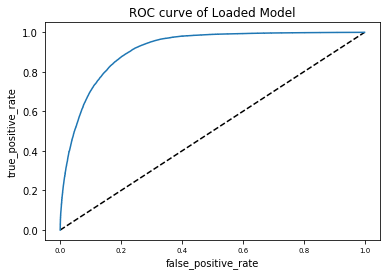

In [317]:
model_evaluation.model_evaluation_test(X_train, y_train, xgb_42, feat_imp=True)

Provided model : 
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=0, n_estimators=250,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
accuracy  90.9092863178632
f1_score  50.760429149867015
precision_score  98.53330424457563
recall_score  34.85970162687608
confusion_matrix 
 [[4594477  432037]
 [  28949   15492]]
roc_auc_score 76.80297854455084


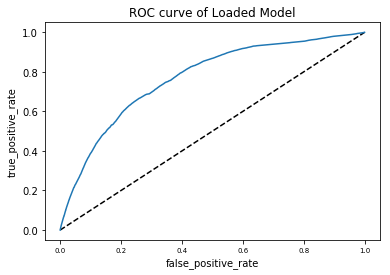

In [313]:
model_evaluation.model_evaluation_test(X_app_rusknn_selected_42, y_old_test, xgb_42)

cross_val_score [0.83234993 0.82770828 0.83193013 0.82610748 0.82177984]
accuracy 82.84001321814662
balanced_accuracy_score 82.90373020560925
f1_score 82.74204614234286
precision_score 83.79403210826452
Log loss 5.926951305734174
recall_score 91.08383290512893


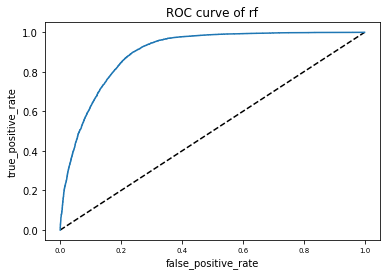

roc_auc_score 89.89032937728562
confusion_matrix [[7976 2698]
 [ 937 9572]]
classification_report              precision    recall  f1-score   support

           0       0.89      0.75      0.81     10674
           1       0.78      0.91      0.84     10509

   micro avg       0.83      0.83      0.83     21183
   macro avg       0.84      0.83      0.83     21183
weighted avg       0.84      0.83      0.83     21183


 Time taken to execute the rf is 0.9158215522766113

Dated on2019-01-23 00:09:12.263526



In [340]:
rf_42= mlModels.rf(X_train, y_train, X_test, y_test, n_estimators=80, min_samples_split=50, criterion='entropy')

Provided model : 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
accuracy  85.28064957749139
f1_score  85.18215900247537
precision_score  86.17690554621343
recall_score  93.19144928901027
confusion_matrix 
 [[24507  7185]
 [ 2169 29688]]
roc_auc_score 93.77260152811728


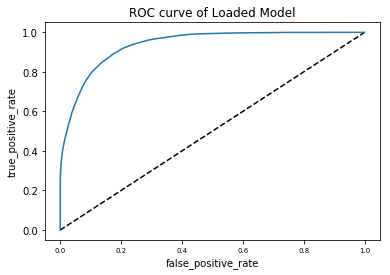

In [341]:
model_evaluation.model_evaluation_test(X_train, y_train, rf_42)

Provided model : 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
accuracy  91.25823439569075
f1_score  50.71522274964886
precision_score  98.50685788085269
recall_score  31.91647352669832
confusion_matrix 
 [[4613480  413034]
 [  30257   14184]]
no_ro_visits_12_18mo 0.010084427194574482
no_ro_visits_0_6mo 0.01121126334375306
est_current_mileage 0.025096598037183337
no_ro_visits_48_60mo 0.005912988896203749
last_reported_mileage_recent_vehicle 0.01807050251023109
has_uss 0.004661818695698214
owned_aqua_vehicle_ind 0.0016040869905221667
owned_silver_gray_vehicle_ind 0.0010251357777245954
avg_custpay_recent_vehicle 0.00871441530

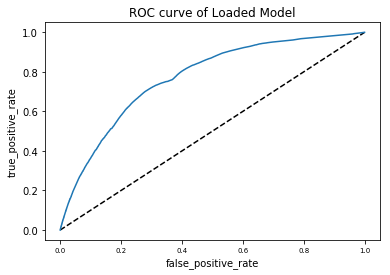

In [343]:
model_evaluation.model_evaluation_test(X_app_rusknn_selected_42, y_old_test, rf_42, feat_imp=True)

In [ ]:
rf_42= mlModels.rf(X_train, y_train, X_test, y_test, n_estimators=150, min_samples_split=40, oob_score=True, criterion='entropy')

In [ ]:
model_evaluation.model_evaluation_test(X_train, y_train, rf_42)

In [ ]:
model_evaluation.model_evaluation_test(X_app_rusknn_selected_42, y_old_test, rf_42)

In [333]:
from xgboost.sklearn import XGBClassifier

In [ ]:
XGBClassifier()

### 70:30